# Modelo de Segmentação G2




## 1. Preparação do Ambiente


### 1.1 Montagem do google drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1.2 Importação das Bibliotecas

In [ ]:
import numpy as np
import re
import pandas as pd
import os
import cv2 as cv
import matplotlib.pyplot as plt
from keras.applications import vgg16
from keras.models import Model, load_model
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD
import pickle
import keras
from keras.layers import Input, Conv2D, Conv2DTranspose, AveragePooling2D, MaxPooling2D, UpSampling2D, LeakyReLU, concatenate, Dropout, BatchNormalization, Activation, SeparableConv2D, DepthwiseConv2D, Add, multiply
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from numpy.random import seed
import concurrent.futures
seed(222)
import tensorflow as tf
from psutil import virtual_memory
from pickle import dump, load
from keras import backend as K
import json
import time


tf.random.set_seed(222)


## 2. Funções Auxiliares

### 2.1 Processamento da Máscara

In [ ]:
def process_mask(mask):
  hsv_mask = cv.cvtColor(mask, cv.COLOR_BGR2HSV)

  lower_red = np.array([0, 50, 50])
  upper_red = np.array([179, 255, 255])

  red_mask = cv.inRange(hsv_mask, lower_red, upper_red)

  head_mask = mask.copy()
  head_mask[red_mask > 0] = [255, 255, 255]

  eyes_mask = np.zeros_like(mask)
  eyes_mask[red_mask > 0] = [255, 255, 255]

  return head_mask, eyes_mask

### 2.2 Salvamento e Carregamento do modelo de Imagens

In [ ]:
def save_images_model(images_model, filename='images_model.pkl'):
    with open(filename, 'wb') as file:
        pickle.dump(images_model, file)
    print(f"Dados salvos no arquivo {filename}")

In [ ]:
def load_images_model(filename):
    with open(filename, 'rb') as file:
        images_model = pickle.load(file)
    print(f"Dados carregados do arquivo {filename}")
    return images_model

### 2.3 Classe Image para Representação das Imagens

In [ ]:
class Image():
  def __init__(self, x_path, y_path, real, mask):
    self.x_path = x_path
    self.y_path = y_path
    self.real = real
    self.mask = mask
    self.head_mask, self.eye_mask = process_mask(mask)

  def getXPath(self):
    return self.x_path

  def getYPath(self):
    return self.y_path

  def getRealImage(self):
    return self.real

  def getMask(self):
    return self.mask

  def getHeadMask(self):
    return self.head_mask

  def getEyeMask(self):
    return self.eye_mask

### 2.4. Carregamento das Imagens

In [ ]:
import cv2 as cv

def load_images(x_path, y_path):
    # Carregar a imagem real
    real_img = cv.imread(x_path)
    if real_img is None:
        print(f"Imagem não encontrada: {x_path}")
        return None

    # Redimensionar a imagem real
    real_img_resized = cv.resize(real_img, (128, 128))

    # Carregar a máscara
    mask_img = cv.imread(y_path)
    if mask_img is None:
        print(f"Máscara não encontrada: {y_path}")
        return None

    # Redimensionar a máscara
    mask_img_resized = cv.resize(mask_img, (128, 128))

    return Image(x_path, y_path, real_img_resized, mask_img_resized)


### 2.5. Processamento Paralelo das Imagens

In [ ]:
import concurrent.futures

def process_images(x_paths, y_paths):
  count = 0
  images_model = []
  with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(load_images, x_paths[i], y_paths[i]) for i in range(len(x_paths))]
    for future in concurrent.futures.as_completed(futures):
      result = future.result()
      if result is not None:
        images_model.append(result)
        print(f"Imagem carregada com sucesso: {count}")
        count += 1
      else:
        print(f"Resultado nulo encontrado para o caminho: {x_paths[count]}")
  return images_model


### 2.6 Metodo para salvar e carregar arquivo com o tempo de execução

In [ ]:
# Função para salvar os tempos de treinamento
def save_times_to_file(filename, cpu_time=None, gpu_time=None):
    data = {
        'cpu_time': cpu_time,
        'gpu_time': gpu_time
    }
    with open(filename, 'w') as file:
        json.dump(data, file)
    print(f"Tempos salvos em {filename}")

# Função para carregar os tempos do arquivo
def load_times_from_file(filename):
    with open(filename, 'r') as file:
        data = json.load(file)

    def format_time(seconds):
        hours = seconds // 3600
        minutes = (seconds % 3600) // 60
        seconds = seconds % 60
        return f"{int(hours)}h {int(minutes)}m {seconds:.2f}s"

    if data.get('cpu_time') is not None:
        data['cpu_time'] = format_time(data['cpu_time'])

    if data.get('gpu_time') is not None:
        data['gpu_time'] = format_time(data['gpu_time'])

    return data


### Metodo para treinar modelo com device especifico

In [ ]:
# Função para treinar o modelo e medir o tempo
def train_model_on_device(device_name, model, X_train, Y_train, callbacks, epochs=41, batch_size=32):
    with tf.device(device_name):
        start_time = time.time()
        history = model.fit(X_train, Y_train, epochs=41, batch_size=32, verbose=1, callbacks=callbacks, shuffle=True)
        end_time = time.time()
        total_time = end_time - start_time
    return total_time, history

## 3. Visualização das Imagens

### Carregando as imagens X e Y


In [ ]:
images = load_images_model(filename="/content/drive/MyDrive/CattleImageRepository/images_model.pkl")

Dados carregados do arquivo /content/drive/MyDrive/CattleImageRepository/images_model.pkl


### Carregando X resultado da segmentação da cabeça


In [ ]:
X_mask = load_images_model(filename="/content/drive/MyDrive/CattleImageRepository/G2/predicao_cabeca.pkl")
X_mask = np.array(X_mask)

Dados carregados do arquivo /content/drive/MyDrive/CattleImageRepository/G2/predicao_cabeca.pkl


In [ ]:
len(images)

3858

### Visualização das imagens X e Y (máscara cabeça e máscara olhos)


/content/drive/MyDrive//CattleImageRepository/G1/01-08-2024/X/01-08-24_video1_00000000205000400_100665_x.png
/content/drive/MyDrive//CattleImageRepository/G1/08-08-2024/Y/01-08-24_video1_00000000205000400_100665_y.png


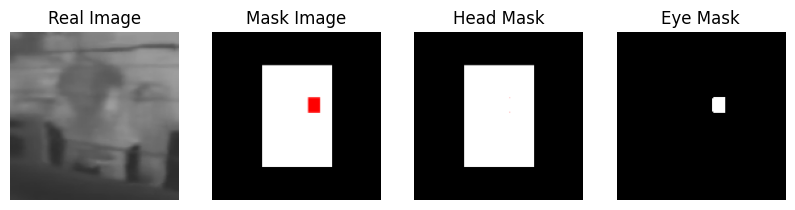

/content/drive/MyDrive//CattleImageRepository/G1/01-08-2024/X/01-08-24_video1_00000000205000400_107520_x.png
/content/drive/MyDrive//CattleImageRepository/G1/01-08-2024/y/01-08-24_video1_00000000205000400_107520_y.png


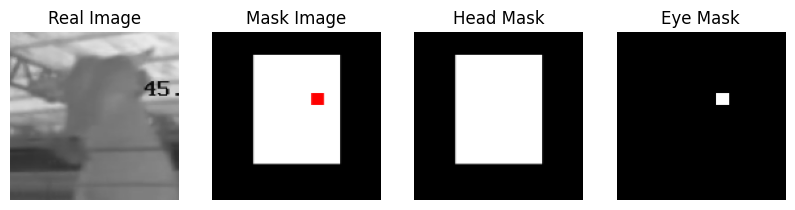

In [ ]:
count = 0
for i in range(len(images)):
  image = images[i]

  x_path = image.getXPath()
  y_path = image.getYPath()
  real = image.getRealImage()
  mask = image.getMask()
  head_mask = image.getHeadMask()
  eye_mask = image.getEyeMask()

  plt.figure(figsize=(10, 5))
  plt.subplot(1, 4, 1)
  plt.imshow(cv.cvtColor(real, cv.COLOR_BGR2RGB), cmap="gray") # Convert from BGR (OpenCV default) to RGB (Matplotlib expects)
  plt.title(f'Real Image')
  plt.axis('off')
  print(x_path)

  plt.subplot(1, 4, 2)
  plt.imshow(cv.cvtColor(mask, cv.COLOR_BGR2RGB), cmap="gray") # Convert from BGR (OpenCV default) to RGB (Matplotlib expects)
  plt.title(f'Mask Image')
  plt.axis('off')
  print(y_path)

  plt.subplot(1, 4, 3)
  plt.imshow(cv.cvtColor(head_mask, cv.COLOR_BGR2RGB), cmap="gray") # Convert from BGR (OpenCV default) to RGB (Matplotlib expects)
  plt.title('Head Mask')
  plt.axis('off')

  plt.subplot(1, 4, 4)
  plt.imshow(cv.cvtColor(eye_mask, cv.COLOR_BGR2RGB), cmap="gray") # Convert from BGR (OpenCV default) to RGB (Matplotlib expects)
  plt.title('Eye Mask')
  plt.axis('off')

  plt.show()
  count += 1
  if count == 2:
    break

## 4. Preparação dos Dados

### 4.1 Extração das Imagens e Máscaras, Normalização dos Dados e Binarização das Máscaras

In [ ]:
# Extrair as imagens e as máscaras de cabeça para o treinamento
X = np.array([image.getRealImage() for image in images])
Y_head = np.array([image.getHeadMask() for image in images])
Y_eye = np.array([image.getEyeMask() for image in images])

# Normalizar os dados para a faixa [0, 1]
X = X / 255.0
Y_head = Y_head / 255.0
Y_eye = Y_eye / 255.0

# Assegurar que as máscaras estão em binário (0 ou 1)
Y_head = (Y_head > 0).astype(np.float32)
Y_eye = (Y_eye > 0).astype(np.float32)

### 4.2 Divisão dos Dados em Treinamento e Teste

In [ ]:
from sklearn.model_selection import train_test_split

# Dividir os dados em treinamento e teste
X_train, X_test, Y_eye_train, Y_eye_test = train_test_split(
    X, Y_eye, test_size=0.2, random_state=42
)


### Visualização da quantidade de dados

In [ ]:
print(f"X shape: {X.shape}")

print(f"Y_eye shape: {Y_eye.shape}")
print(f"X_train shape: {X_train.shape}")

print(f"Y_eye_train shape: {Y_eye_train.shape}")
print(f"X_test shape: {X_test.shape}")

print(f"Y_eye_test shape: {Y_eye_test.shape}")


X shape: (3858, 128, 128, 3)
Y_eye shape: (3858, 128, 128, 3)
X_train shape: (3086, 128, 128, 3)
Y_eye_train shape: (3086, 128, 128, 3)
X_test shape: (772, 128, 128, 3)
Y_eye_test shape: (772, 128, 128, 3)


## 5. Treinando Modelo


### 5.4 Funções de Perda

In [ ]:
def dice_loss(y_true, y_pred):
    smooth = 1.0  # Evita divisão por zero

    # Flatten the tensors using tf.keras.layers.Flatten()
    flatten = tf.keras.layers.Flatten()
    y_true_f = flatten(y_true)
    y_pred_f = flatten(y_pred)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

In [ ]:
def combined_loss(y_true, y_pred):
    bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce_loss + dice

## Carregando modelo treinado com a cabeça


In [ ]:
# Carregando modelo
TransferLearningModel = load_model('/content/drive/MyDrive/CattleImageRepository/G2/segmentacao.keras', custom_objects={'dice_loss': dice_loss, })

### 5.5 Compilação do Modelo

In [ ]:
TransferLearningModel.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 128, 128, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 64, 64, 64)     │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 64, 64, 128)    │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 64, 64, 128)    │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 32, 32, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 32, 32, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 16, 16, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 16, 16, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 8, 8, 512)      │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 8, 8, 512)      │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 8, 8, 512)      │      2,359,808 │ block5_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv3 (Conv2D)

 Total params: 55,344,587 (211.12 MB)

 Trainable params: 18,447,235 (70.37 MB)

 Non-trainable params: 2,880 (11.25 KB)

 Optimizer params: 36,894,472 (140.74 MB)

## 6. Treinamento e Salvamento do Modelo

### Definindo Early Stopping


In [ ]:
early_stopping = EarlyStopping(monitor='accuracy',
                               patience=5,
                               restore_best_weights=True)

## Processo com gpu

### 6.1 Treinamento do Modelo

In [ ]:
tf.config.run_functions_eagerly(True)
gpu_time_first, gpu_history_first = train_model_on_device('/GPU:0', TransferLearningModel, X_train, Y_eye_train, [early_stopping], epochs=41, batch_size=32, )

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/41
97/97 ━━━━━━━━━━━━━━━━━━━━ 66s 511ms/step - accuracy: 0.4213 - loss: 0.8731 - precision: 0.0654 - recall: 0.9231
Epoch 2/41
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 450ms/step - accuracy: 0.5374 - loss: 0.6695 - precision: 0.2667 - recall: 0.8385
Epoch 3/41
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 449ms/step - accuracy: 0.5253 - loss: 0.5282 - precision: 0.4075 - recall: 0.7538
Epoch 4/41
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 449ms/step - accuracy: 0.5288 - loss: 0.4588 - precision: 0.4839 - recall: 0.7059
Epoch 5/41
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 450ms/step - accuracy: 0.5197 - loss: 0.4176 - precision: 0.5355 - recall: 0.6928
Epoch 6/41
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 451ms/step - accuracy: 0.5205 - loss: 0.3897 - precision: 0.5677 - recall: 0.6958
Epoch 7/41
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 451ms/step - accuracy: 0.5182 - loss: 0.3770 - precision: 0.5904 - recall: 0.6865


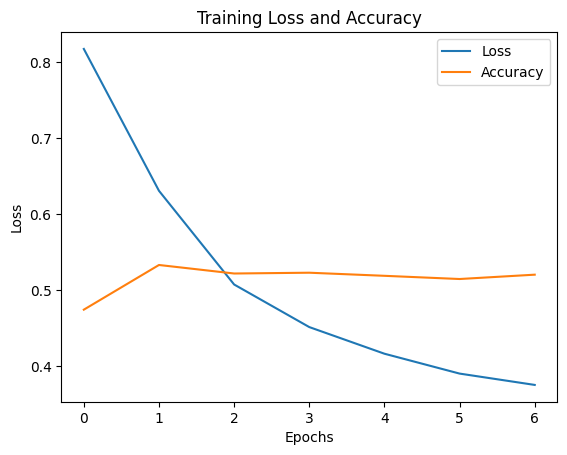

In [ ]:
# Dados
training_loss = gpu_history_first.history['loss']
accuracy = gpu_history_first.history['accuracy']

# Plot
plt.plot(training_loss, label='Loss')
plt.plot(accuracy, label='Accuracy')
plt.title('Tra ining Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
prediction_1 = TransferLearningModel.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step


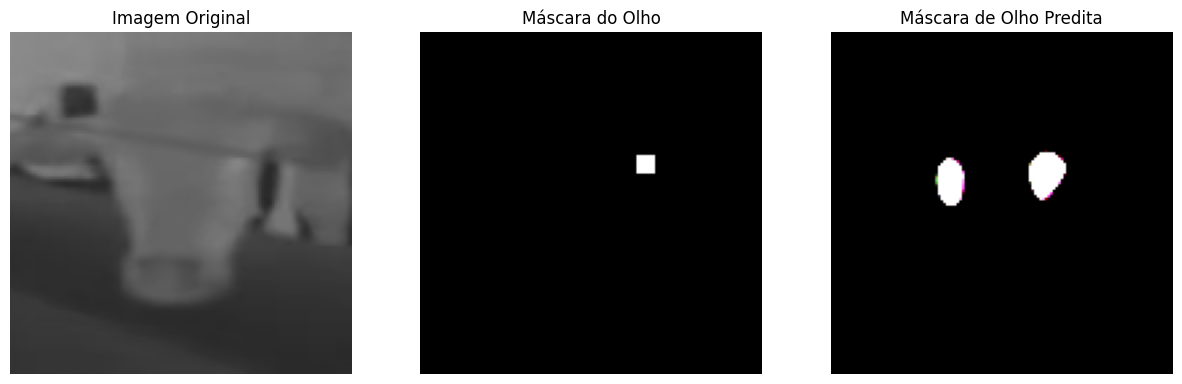

In [ ]:
import matplotlib.pyplot as plt

# Configuração do layout para 1 linha e 3 colunas
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Imagem original
axs[0].imshow(X_test[300])
axs[0].set_title("Imagem Original")
axs[0].axis('off')

# Máscara de olho real
real_mask = Y_eye_test[300]
axs[1].imshow(real_mask, cmap='gray')
axs[1].set_title("Máscara do Olho")
axs[1].axis('off')

# Máscara de olho predita
pred_mask = prediction_1[300]
axs[2].imshow(pred_mask, cmap='gray')
axs[2].set_title("Máscara de Olho Predita")
axs[2].axis('off')

# Exibindo as imagens
plt.show()


### Retreinando


In [ ]:
from sklearn.model_selection import train_test_split

# Dividir os dados em treinamento e teste
X_train_mask, X_test_mask, Y_eye_train, Y_eye_test = train_test_split(
    X_mask, Y_eye, test_size=0.2, random_state=42
)


In [ ]:
tf.config.run_functions_eagerly(True)
gpu_time_second, gpu_history_second = train_model_on_device('/GPU:0', TransferLearningModel, X_train_mask, Y_eye_train, [early_stopping], epochs=41, batch_size=32, )

Epoch 1/41
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 449ms/step - accuracy: 0.5334 - loss: 0.5392 - precision: 0.3918 - recall: 0.7589
Epoch 2/41
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 452ms/step - accuracy: 0.5256 - loss: 0.4550 - precision: 0.4863 - recall: 0.7171
Epoch 3/41
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 450ms/step - accuracy: 0.5066 - loss: 0.4182 - precision: 0.5347 - recall: 0.6946
Epoch 4/41
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 448ms/step - accuracy: 0.5075 - loss: 0.3982 - precision: 0.5565 - recall: 0.6932
Epoch 5/41
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 450ms/step - accuracy: 0.5307 - loss: 0.3769 - precision: 0.5859 - recall: 0.6921


In [ ]:
save_times_to_file('/content/drive/MyDrive/CattleImageRepository/G2/times_model_eyes.json', gpu_time=gpu_time_first + gpu_time_second)

Tempos salvos em /content/drive/MyDrive/CattleImageRepository/G2/times_model_eyes.json


In [ ]:
prediction_2 = TransferLearningModel.predict(X_test_mask)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


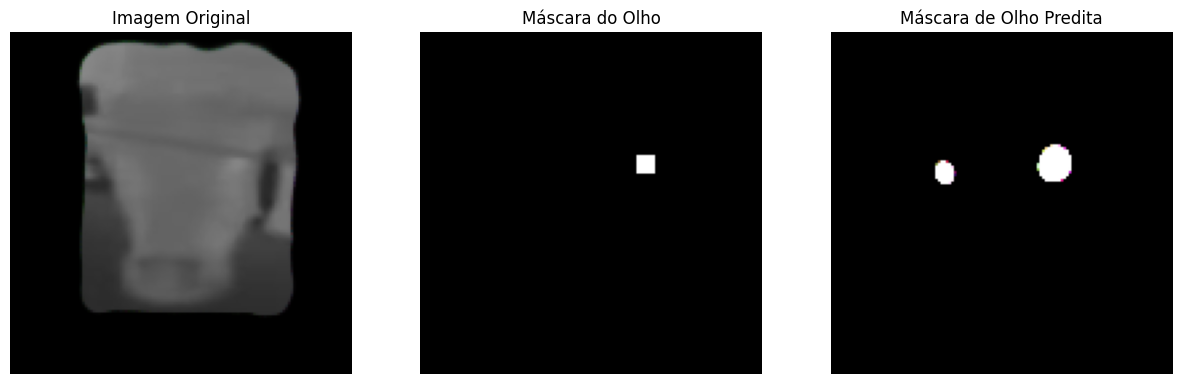

In [ ]:
import matplotlib.pyplot as plt

# Configuração do layout para 1 linha e 3 colunas
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Imagem original
axs[0].imshow(X_test_mask[300])
axs[0].set_title("Imagem Original")
axs[0].axis('off')

# Máscara de olho real
real_mask = Y_eye_test[300]
axs[1].imshow(real_mask, cmap='gray')
axs[1].set_title("Máscara do Olho")
axs[1].axis('off')

# Máscara de olho predita
pred_mask = prediction_2[300]
axs[2].imshow(pred_mask, cmap='gray')
axs[2].set_title("Máscara de Olho Predita")
axs[2].axis('off')

# Exibindo as imagens
plt.show()


## Processo com cpu

### 6.1 Treinamento do Modelo

In [ ]:
tf.config.run_functions_eagerly(True)
cpu_time_first, cpu_history_first = train_model_on_device('/CPU:0', TransferLearningModel, X_train, Y_eye_train, [early_stopping], epochs=41, batch_size=32, )

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/41
97/97 ━━━━━━━━━━━━━━━━━━━━ 1168s 12s/step - accuracy: 0.4196 - loss: 0.8735 - precision: 0.0653 - recall: 0.9231
Epoch 2/41
97/97 ━━━━━━━━━━━━━━━━━━━━ 1200s 12s/step - accuracy: 0.5352 - loss: 0.6713 - precision: 0.2641 - recall: 0.8443
Epoch 3/41
97/97 ━━━━━━━━━━━━━━━━━━━━ 1194s 12s/step - accuracy: 0.5279 - loss: 0.5303 - precision: 0.3985 - recall: 0.7669
Epoch 4/41
97/97 ━━━━━━━━━━━━━━━━━━━━ 1188s 12s/step - accuracy: 0.5146 - loss: 0.4577 - precision: 0.4900 - recall: 0.7057
Epoch 5/41
47/97 ━━━━━━━━━━━━━━━━━━━━ 11:16 14s/step - accuracy: 0.5124 - loss: 0.4207 - precision: 0.5331 - recall: 0.6965

# Comparação de Tempo de Treinamento entre CPU e GPU para Segmentação de Imagens

Nesta seção, comparamos o tempo de treinamento de um modelo de segmentação de imagens utilizando a CPU e a GPU. Abaixo estão os prints que mostram o tempo de execução de ambos os dispositivos:

- **Tempo de Treinamento na GPU:**

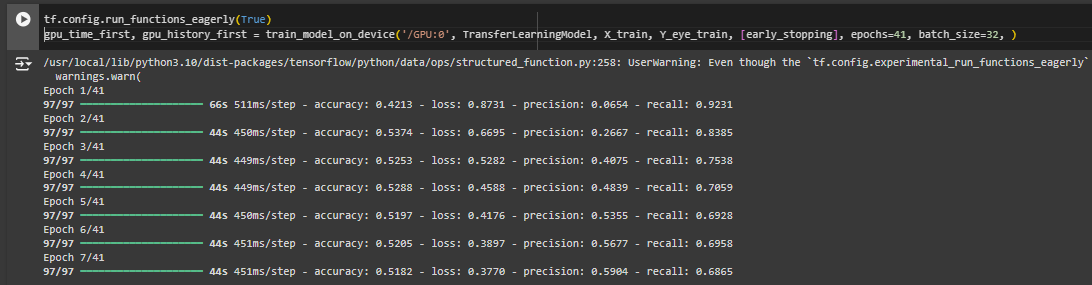

- **Tempo de Treinamento na CPU:**

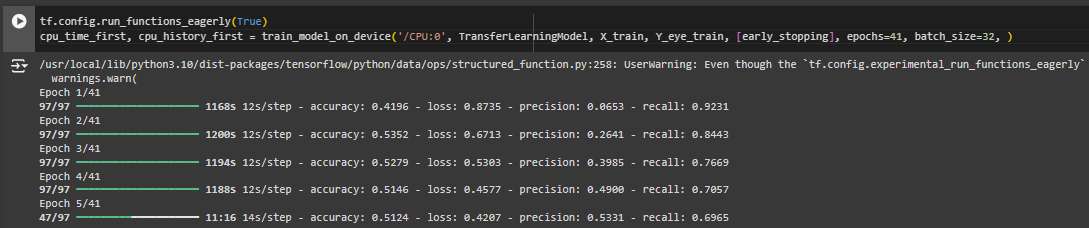

## Análise:

### 1. Tempo de Treinamento na GPU:
- O treinamento na GPU foi concluído em apoximadamente 5 minutos e meio, demonstrando uma grande eficiência no processamento paralelo, crucial para tarefas como segmentação de imagens.
- O desempenho superior da GPU se deve à sua arquitetura, que é otimizada para lidar com operações massivamente paralelas, essenciais para o processamento de grandes conjuntos de imagens em tarefas de segmentação.

### 2. Tempo de Treinamento na CPU:
- O treinamento na CPU foi interrompido após aproximadamente 1 hora e meia, sem que o processo fosse concluído. Isso indica a dificuldade da CPU em lidar com o processamento intensivo necessário para a segmentação de imagens, que envolve grandes volumes de dados e operações matemáticas complexas.
- A demora no treinamento torna a CPU uma escolha menos eficiente para esse tipo de tarefa, reforçando a importância de usar aceleradores como a GPU.

## Conclusão:

O treinamento do modelo de segmentação de imagens na CPU foi impraticável, levando mais de 1 hora sem ser finalizado. Em contrapartida, a GPU conseguiu completar o processo em um tempo significativamente menor. Para tarefas de segmentação, que envolvem grandes volumes de dados e cálculos intensivos, a GPU é claramente a escolha mais eficiente, oferecendo uma melhoria drástica no tempo de treinamento e na capacidade de iterar e ajustar o modelo mais rapidamente.


## 7. Coletando a temperatura

### 7.1 Funções para coletar a temperatura

In [ ]:
def only_eyes(image_original,image_predita):
  """
    Parameters:
      image_original: Contexto  X image 128x128
      image_predita: output do modelo de sementação dos olhos image 128x128
    Returns: Imagem original com área preta fora dos olhos
    """
  img1 = image_predita
  img2 = image_original
  mask = img1 > 0.5 #seleciono apenas os pixeis que não são pretos na imagem predita
  img2_eyes = np.zeros_like(img2) #crio uma imagem vazia com as mesmas dimensões da imagem original

  img2_eyes[mask] = img2[mask]# faço a máscara dos olhos na imagem original

  return img2_eyes


In [ ]:
def get_temp_from_pixel(pixel, temp_tuple):
    """
    Parameters:
      pix: rgb color tuple representing image pixel
      temp_tuple: (min, max) temperature tuple representing the temperature scale
    Returns: °C tempertature from pixel
    """
    MIN_TEMP_PIXEL = 32 / 255.0
    MAX_TEMP_PIXEL = 159 / 255.0
    TEMP_PIXEL_RANGE = MAX_TEMP_PIXEL - MIN_TEMP_PIXEL

    if pixel < MIN_TEMP_PIXEL: pixel = MIN_TEMP_PIXEL
    if pixel > MAX_TEMP_PIXEL: pixel = MAX_TEMP_PIXEL

    min_temp = min(temp_tuple)
    max_temp = max(temp_tuple)
    temp_range = max_temp - min_temp

    temp = min_temp + ((pixel - MIN_TEMP_PIXEL) / TEMP_PIXEL_RANGE) * temp_range

    return temp


In [ ]:
def get_temp_olhos(image_original,image_predita, temp_tupla):
  """
    Parameters:
      image_original: Contexto  X image 128x128
      image_predita: output do modelo de sementação dos olhos image 128x128
      temp_tuple: (min, max) tupla de temperatura representando o intervalo de temperatura
    Returns: °C tempertatura dos olhos bovinos
    """
  img = only_eyes(image_original,image_predita)
  img_ble = img[img > 0.1]
  media = np.mean(img_ble)
  return get_temp_from_pixel(media, temp_tupla)

In [ ]:
# Exemplo de como utilizar
min_temp = 19.3
max_temp = 41
temp = get_temp_olhos(X_test[230],prediction[230], (min_temp, max_temp))